In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import re #regular expressions
import plotly.express as px
# Plotting
import matplotlib.pylab as plt
import seaborn as sns

#Progress bar
from tqdm import tqdm
from datetime import datetime
import os
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/novel-corona-virus-2019-dataset/time_series_covid_19_confirmed.csv
/kaggle/input/novel-corona-virus-2019-dataset/time_series_covid_19_deaths_US.csv
/kaggle/input/novel-corona-virus-2019-dataset/time_series_covid_19_recovered.csv
/kaggle/input/novel-corona-virus-2019-dataset/COVID19_open_line_list.csv
/kaggle/input/novel-corona-virus-2019-dataset/time_series_covid_19_deaths.csv
/kaggle/input/novel-corona-virus-2019-dataset/covid_19_data.csv
/kaggle/input/novel-corona-virus-2019-dataset/time_series_covid_19_confirmed_US.csv
/kaggle/input/novel-corona-virus-2019-dataset/COVID19_line_list_data.csv


In [2]:
#upload the data
path = '../input/novel-corona-virus-2019-dataset/covid_19_data.csv'

In [3]:
#loading datasets
covid_df = pd.read_csv(path)

In [4]:
#Split the date column into month and year then add those two columns

covid_df.ObservationDate = covid_df.ObservationDate.apply(lambda x: x.replace('/', '-'))
covid_df['observation_date']= pd.to_datetime(covid_df['ObservationDate']) 

#coverting last update into datetime



covid_df['last_update'] = covid_df['Last Update'].apply(lambda x: x.replace('/', '-'))
covid_df['last_update']= pd.to_datetime(covid_df['Last Update']) 

covid_df.head()


,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,observation_date,last_update
0,1,01-22-2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0,2020-01-22,2020-01-22 17:00:00
1,2,01-22-2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0,2020-01-22,2020-01-22 17:00:00
2,3,01-22-2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0,2020-01-22,2020-01-22 17:00:00
3,4,01-22-2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0,2020-01-22,2020-01-22 17:00:00
4,5,01-22-2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0,2020-01-22,2020-01-22 17:00:00


In [5]:
# last_update, timestamp = zip(*[(d.date(), d.time()) for d in covid_df['last_update']])
# covid_df = covid_df.assign(last_update=last_update, update_time=timestamp)
# covid_df.head()

In [6]:
covid_df.dtypes


SNo                          int64
ObservationDate             object
Province/State              object
Country/Region              object
Last Update                 object
Confirmed                  float64
Deaths                     float64
Recovered                  float64
observation_date    datetime64[ns]
last_update         datetime64[ns]
dtype: object

In [7]:
covid_df['last_update']= pd.to_datetime(covid_df['last_update']) 

covid_df.dtypes


SNo                          int64
ObservationDate             object
Province/State              object
Country/Region              object
Last Update                 object
Confirmed                  float64
Deaths                     float64
Recovered                  float64
observation_date    datetime64[ns]
last_update         datetime64[ns]
dtype: object

In [8]:
covid_df=covid_df.drop(['Province/State','Last Update', 'ObservationDate'], 1, inplace= False)

In [9]:
#lower case
covid_df.columns = map(str.lower, covid_df.columns)
covid_df.columns

Index(['sno', 'country/region', 'confirmed', 'deaths', 'recovered',
       'observation_date', 'last_update'],
      dtype='object')

# Modeling

In [10]:
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

from fbprophet.plot import plot_plotly

In [11]:
covid_train=pd.DataFrame(covid_df.groupby('last_update')['deaths'].sum())
covid_one=pd.DataFrame(covid_df.groupby('last_update')['deaths', 'confirmed', 'recovered'].sum())

covid_train.shape
covid_one.head()


,deaths,confirmed,recovered
last_update,,,
2020-01-22 17:00:00,17.0,555.0,28.0
2020-01-23 17:00:00,18.0,653.0,30.0
2020-01-24 17:00:00,26.0,941.0,36.0
2020-01-25 17:00:00,42.0,1438.0,39.0
2020-01-26 16:00:00,56.0,2118.0,52.0


In [12]:
covid_train=covid_train.reset_index() \
              .rename(columns={'last_update':'ds',
                               'deaths':'y'})
covid_train.head()

,ds,y
0,2020-01-22 17:00:00,17.0
1,2020-01-23 17:00:00,18.0
2,2020-01-24 17:00:00,26.0
3,2020-01-25 17:00:00,42.0
4,2020-01-26 16:00:00,56.0


In [13]:
# Setup and train model and fit
from fbprophet import Prophet
model = Prophet()
model.fit(covid_train.reset_index() \
              .rename(columns={'last_update':'ds',
                               'deaths':'y'}))

future = model.make_future_dataframe(periods=365)
recoverd_predicted = model.predict(future)
future.tail()

,ds
2196,2021-04-23 02:31:20
2197,2021-04-24 02:31:20
2198,2021-04-25 02:31:20
2199,2021-04-26 02:31:20
2200,2021-04-27 02:31:20


In [14]:
# Predict on training set with model
covid_test_fcst = model.predict(df=covid_train.reset_index() \
                                   .rename(columns={'last_update':'ds'}))

In [15]:
covid_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-22 17:00:00,-490.440085,-7846.880610,6259.229508,-490.440085,-490.440085,-515.741211,-515.741211,-515.741211,-218.676172,-218.676172,-218.676172,-297.065040,-297.065040,-297.065040,0.0,0.0,0.0,-1006.181297
1,2020-01-23 17:00:00,-469.987804,-8459.582059,4963.187626,-469.987804,-469.987804,-1403.238095,-1403.238095,-1403.238095,-218.676172,-218.676172,-218.676172,-1184.561923,-1184.561923,-1184.561923,0.0,0.0,0.0,-1873.225900
2,2020-01-24 17:00:00,-449.535524,-8962.825490,4087.995248,-449.535524,-449.535524,-2081.876956,-2081.876956,-2081.876956,-218.676172,-218.676172,-218.676172,-1863.200784,-1863.200784,-1863.200784,0.0,0.0,0.0,-2531.412480
3,2020-01-25 17:00:00,-429.083243,-6823.290339,7687.076645,-429.083243,-429.083243,534.432161,534.432161,534.432161,-218.676172,-218.676172,-218.676172,753.108333,753.108333,753.108333,0.0,0.0,0.0,105.348918
4,2020-01-26 16:00:00,-409.483141,-6707.218770,7229.577768,-409.483141,-409.483141,838.537496,838.537496,838.537496,-436.610070,-436.610070,-436.610070,1275.147565,1275.147565,1275.147565,0.0,0.0,0.0,429.054355


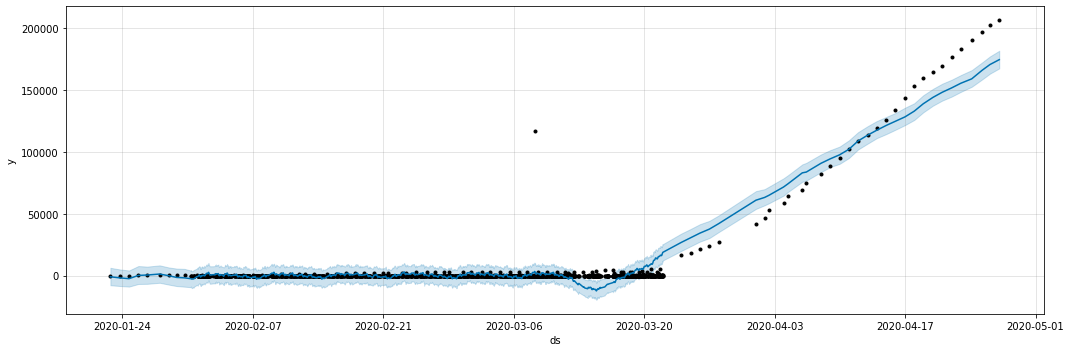

In [16]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(covid_test_fcst,
                 ax=ax)
plt.show()

In [17]:
future = model.make_future_dataframe(periods=365)
fatalities_predict = model.predict(future)

In [18]:
fig = plot_plotly(model, fatalities_predict)  
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Predictions : Covid 19 confirmed cases',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
fig.update_layout(annotations=annotations)
fig

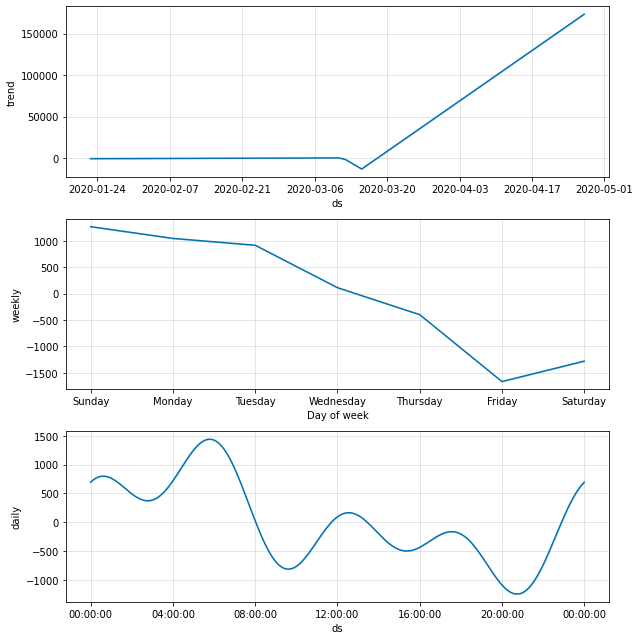

In [19]:
# Plot the components of the model
fig = model.plot_components(covid_test_fcst)

In [20]:
mse=mean_squared_error(y_true=covid_train['y'],
                   y_pred=covid_test_fcst['yhat'])
mse

29276553.28842085

In [21]:
#Root means squared error
from math import sqrt
rmse=sqrt(mse)
rmse


5410.781208699983

## Evaluation

In [22]:
covid_train.shape

(1836, 2)

In [23]:
m = Prophet()
m.fit(covid_train.reset_index() \
              .rename(columns={'last_update':'ds',
                               'deaths':'y'}))
future = m.make_future_dataframe(periods=366)

In [24]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='53 days', period='366 days', horizon = '22 days')
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-04-05 23:13:44,26223.365369,21718.037873,31038.078714,69374.0,2020-04-05 02:31:20
1,2020-04-06 09:37:00,26113.033312,21575.434157,30531.882039,74565.0,2020-04-05 02:31:20
2,2020-04-07 23:11:31,28685.173627,23774.647973,33492.107447,81865.0,2020-04-05 02:31:20
3,2020-04-08 22:59:00,29972.111978,25233.181211,34412.310769,88338.0,2020-04-05 02:31:20
4,2020-04-09 23:09:19,30581.455811,26105.920817,35234.577811,95455.0,2020-04-05 02:31:20
5,2020-04-10 23:01:43,32052.217357,27441.697091,36638.978480,102525.0,2020-04-05 02:31:20
6,2020-04-11 22:52:46,34203.372583,29307.832962,38849.749091,108502.0,2020-04-05 02:31:20
7,2020-04-12 23:25:00,35351.360030,30318.130330,40062.772134,114089.0,2020-04-05 02:31:20
8,2020-04-13 23:15:42,36556.592352,31315.598391,41648.281289,119482.0,2020-04-05 02:31:20
9,2020-04-14 23:41:11,37816.219251,32194.938811,42747.305623,125984.0,2020-04-05 02:31:20


In [25]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days 07:05:40,2.104785e+09,45877.937753,45801.300659,0.635898,0.635898,0.0
1,2 days 20:40:11,2.587844e+09,50870.851226,50815.896530,0.649699,0.649699,0.0
2,3 days 20:27:40,3.117335e+09,55833.103163,55772.857197,0.655157,0.655157,0.0
3,4 days 20:37:59,3.807577e+09,61705.565471,61619.716105,0.670168,0.670168,0.0
4,5 days 20:30:23,4.587495e+09,67731.048379,67673.163416,0.683498,0.683498,0.0
5,6 days 20:21:26,5.243350e+09,72410.976825,72385.705030,0.686070,0.686070,0.0
6,7 days 20:53:40,5.859951e+09,76550.316734,76518.133693,0.687455,0.687455,0.0
7,8 days 20:44:22,6.538120e+09,80858.639556,80831.523809,0.692092,0.692092,0.0
8,9 days 21:09:51,7.325090e+09,85586.741952,85546.594199,0.696937,0.696937,0.0
9,10 days 20:33:06,8.406083e+09,91684.691719,91619.686962,0.704193,0.704193,0.0


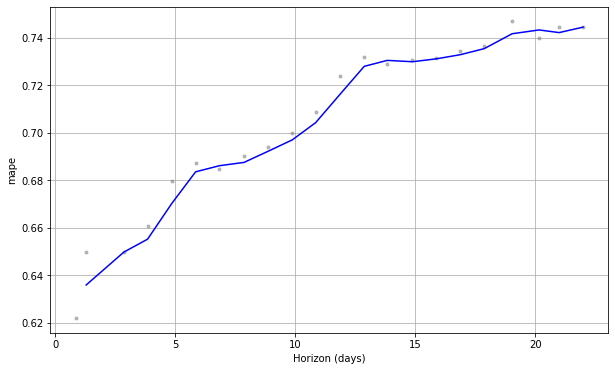

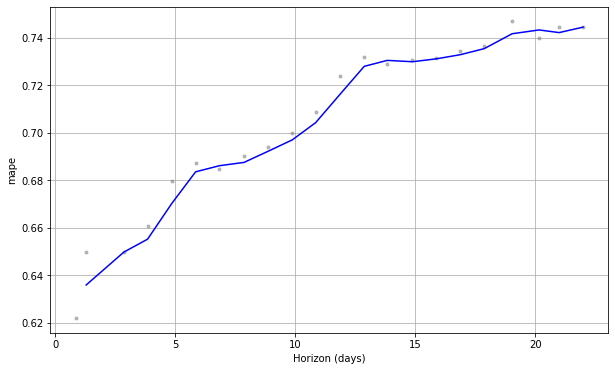

In [26]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')
fig

## Neural networks

## Feature Engineering

### Creating dataframes for recovered and confirmed cases.

In [27]:
covid_two=pd.DataFrame(covid_df.groupby('last_update')['confirmed'].sum())

covid_two.head()

,confirmed
last_update,
2020-01-22 17:00:00,555.0
2020-01-23 17:00:00,653.0
2020-01-24 17:00:00,941.0
2020-01-25 17:00:00,1438.0
2020-01-26 16:00:00,2118.0


In [28]:
covid_two=covid_two.reset_index() \
              .rename(columns={'last_update':'ds',
                               'confirmed':'c'})
covid_two.head()

,ds,c
0,2020-01-22 17:00:00,555.0
1,2020-01-23 17:00:00,653.0
2,2020-01-24 17:00:00,941.0
3,2020-01-25 17:00:00,1438.0
4,2020-01-26 16:00:00,2118.0


In [29]:
covid_one=pd.DataFrame(covid_df.groupby('last_update')['recovered'].sum())

covid_one.head()

,recovered
last_update,
2020-01-22 17:00:00,28.0
2020-01-23 17:00:00,30.0
2020-01-24 17:00:00,36.0
2020-01-25 17:00:00,39.0
2020-01-26 16:00:00,52.0


In [30]:
covid_one=covid_one.reset_index() \
              .rename(columns={'last_update':'ds',
                               'recovered':'r'})
covid_one.head()

,ds,r
0,2020-01-22 17:00:00,28.0
1,2020-01-23 17:00:00,30.0
2,2020-01-24 17:00:00,36.0
3,2020-01-25 17:00:00,39.0
4,2020-01-26 16:00:00,52.0


### Dropping the date column

In [31]:
covid_one=covid_one.drop(['ds'], 1, inplace=False)
covid_two=covid_two.drop(['ds'], 1, inplace=False)


In [32]:
covid=covid_train.drop(['ds'], 1, inplace=False)
covid.head()

,y
0,17.0
1,18.0
2,26.0
3,42.0
4,56.0


In [33]:
covid.shape

(1836, 1)

In [34]:
covid_one.shape

(1836, 1)

### Joining the confirmed and recovered cases dataset

In [35]:
covid_new = covid_one.join(covid_two)
covid_new.head()

,r,c
0,28.0,555.0
1,30.0,653.0
2,36.0,941.0
3,39.0,1438.0
4,52.0,2118.0


## Model

In [36]:
X= covid_new
Y=covid

In [37]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Import an Multi-Layer Perceptron Regressor model estimator from Scikit-Learn's neural_network library
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
from sklearn import metrics

In [38]:
min_max_scaler = preprocessing.MinMaxScaler()
X_scale = min_max_scaler.fit_transform(X)

In [39]:
from sklearn.model_selection import train_test_split

In [40]:
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X_scale, Y, test_size=0.3)

In [41]:
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)

In [42]:
print(X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape)

(1285, 2) (275, 2) (276, 2) (1285, 1) (275, 1) (276, 1)


In [43]:
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [44]:
model = Sequential([
    Dense(32, activation='relu', input_shape=(2,)),
    Dense(32, activation='relu'),
    Dense(1, activation='relu'),
])

In [45]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [46]:
hist = model.fit(X_train, Y_train,
          batch_size=32, epochs=7,
          validation_data=(X_val, Y_val))

Train on 1285 samples, validate on 275 samples
Epoch 1/7
1285/1285 [==============================] - 0s 331us/step - loss: 31960.8302 - accuracy: 0.4163 - val_loss: 14642.1468 - val_accuracy: 0.4073
Epoch 2/7
1285/1285 [==============================] - 0s 54us/step - loss: 31960.8291 - accuracy: 0.4163 - val_loss: 14642.1468 - val_accuracy: 0.4073
Epoch 3/7
1285/1285 [==============================] - 0s 54us/step - loss: 31960.8299 - accuracy: 0.4163 - val_loss: 14642.1468 - val_accuracy: 0.4073
Epoch 4/7
1285/1285 [==============================] - 0s 55us/step - loss: 31960.8296 - accuracy: 0.4163 - val_loss: 14642.1468 - val_accuracy: 0.4073
Epoch 5/7
1285/1285 [==============================] - 0s 54us/step - loss: 31960.8296 - accuracy: 0.4163 - val_loss: 14642.1468 - val_accuracy: 0.4073
Epoch 6/7
1285/1285 [==============================] - 0s 55us/step - loss: 31960.8305 - accuracy: 0.4163 - val_loss: 14642.1468 - val_accuracy: 0.4073
Epoch 7/7
1285/1285 [===================

In [47]:
model.evaluate(X_test, Y_test)[1]

276/276 [==============================] - 0s 31us/step


0.3695652186870575

In [48]:
import matplotlib.pyplot as plt

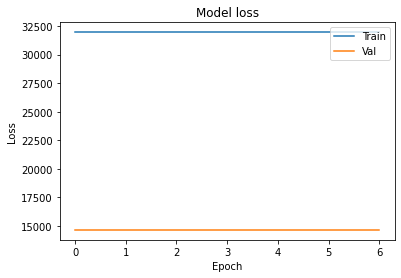

In [49]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()